# Libraries, packages

In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
! pip install adjustText

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7097 sha256=307e6dbc0ad6b7f382b33d7b2ae660bc0354d3dca956c8b5515d7a431f5377eb
  Stored in directory: /root/.cache/pip/wheels/2f/98/32/afbf902d8f040fadfdf0a44357e4ab750afe165d873bf5893d
Successfully built adjustText


In [ ]:
! python -m spacy download en_core_web_md

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 33.5 MB 280 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [ ]:
! pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=6f403abb95d81ddfd51bf1715134811625fbd9abb19ac23a1ad2a324add35942
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [ ]:
! pip install emoji --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 7.9 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=573fe45855b05e0e98cb8b237d30d33c9ea975192b2ffa939a537a4372344870
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


In [ ]:
! pip install bcolz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 8.1 MB/s 
  Created wheel for bcolz: filename=bcolz-1.2.1-cp37-cp37m-linux_x86_64.whl size=2650031 sha256=f1a783caeffbeb416e4ff9ffad98790f5e3393f39046b3951dd58ae63837be68
  Stored in directory: /root/.cache/pip/wheels/2c/35/ca/9d914de345914e2446ea285170329f771b8abba2a00f7650bd
Successfully built bcolz


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import spacy
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import emoji
import pickle
import bcolz
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torchviz import make_dot
import time
import random
import en_core_web_md
nlp = en_core_web_md.load()
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from tqdm.auto import tqdm,trange
import re, string, unicodedata
from string import punctuation
from collections import defaultdict
from torch.utils.data.dataloader import default_collate
device = torch.device("cuda:0")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Without pre-trained embeddings

## Import

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Deep Learning/Covid sentiment/Corona_NLP_train.csv', encoding='ISO-8859-1')
test_df = pd.read_csv('/content/drive/MyDrive/Deep Learning/Covid sentiment/Corona_NLP_test.csv')

In [ ]:
train_df = train_df[['OriginalTweet', 'Sentiment']]
test_df = test_df[['OriginalTweet', 'Sentiment']]

In [ ]:
train_df['Sentiment'] = train_df['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})
test_df['Sentiment'] = test_df['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

## Data Cleaning

In [ ]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [ ]:
#Clean emojis from text
def strip_emoji(text):
    return re.sub(emoji.get_emoji_regexp(), r"", text) 

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

# urls
def remove_url(text):
    return re.sub(r'http\S+', '', text)

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

In [ ]:
train_df['OriginalTweet'] = train_df['OriginalTweet'].apply(lambda x: strip_emoji(x))
test_df['OriginalTweet'] = test_df['OriginalTweet'].apply(lambda x: strip_emoji(x))

train_df['OriginalTweet'] = train_df['OriginalTweet'].apply(lambda x: strip_all_entities(x))
test_df['OriginalTweet'] = test_df['OriginalTweet'].apply(lambda x: strip_all_entities(x))

train_df['OriginalTweet'] = train_df['OriginalTweet'].apply(lambda x: clean_hashtags(x))
test_df['OriginalTweet'] = test_df['OriginalTweet'].apply(lambda x: clean_hashtags(x))

train_df['OriginalTweet'] = train_df['OriginalTweet'].apply(lambda x: filter_chars(x))
test_df['OriginalTweet'] = test_df['OriginalTweet'].apply(lambda x: filter_chars(x))

train_df['OriginalTweet'] = train_df['OriginalTweet'].apply(lambda x: remove_mult_spaces(x))
test_df['OriginalTweet'] = test_df['OriginalTweet'].apply(lambda x: remove_mult_spaces(x))

train_df['OriginalTweet'] = train_df['OriginalTweet'].apply(lambda x: remove_stopwords(x))
test_df['OriginalTweet'] = test_df['OriginalTweet'].apply(lambda x: remove_stopwords(x))

train_df['OriginalTweet'] = train_df['OriginalTweet'].apply(lambda x: remove_url(x))
test_df['OriginalTweet'] = test_df['OriginalTweet'].apply(lambda x: remove_url(x))

train_df['OriginalTweet'] = train_df['OriginalTweet'].apply(lambda x: denoise_text(x))
test_df['OriginalTweet'] = test_df['OriginalTweet'].apply(lambda x: denoise_text(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
print(len(train_df[train_df['OriginalTweet'].str.contains('19')]))
print(len(train_df[train_df['OriginalTweet'].str.contains('covid 19')]))
print(len(train_df[train_df['OriginalTweet'].str.contains('covid19')]))

21472
2758
16325


## Vocabulary

In [ ]:
df = pd.concat([train_df, test_df], ignore_index=True)

In [ ]:
content_words=[]

for text in tqdm(df['OriginalTweet']):
    with nlp.disable_pipes("tagger","parser","ner"):
        doc = nlp(text)
        content_words.append([token.text.lower() for token in doc])

  0%|          | 0/44955 [00:00<?, ?it/s]

In [ ]:
df['content_words'] = content_words

In [ ]:
df['len'] = [len(content) for content in df['content_words']]

In [ ]:
class WordTokenizer(): # occurrences of the words in the corpus
    def __init__(self, tok_seqs, threshold=15): 
        tok_counts={} # keys: words, values: occurrences
        
        for tok_seq in tqdm(tok_seqs): # iterate over the list of words in each row in the df
            for tok in tok_seq:
                if not tok in tok_counts.keys():
                    tok_counts[tok]=1
                else:
                    tok_counts[tok]+=1
        
        self.vocab={'[PAD]':0,'[UNK]':1} # initialize vocab attribute with padding and unknown
        for tok, val in tok_counts.items(): # iterate over the values in the previously created dictionary (words:occurrences dict)
            if val>=threshold:
                self.vocab[tok]=len(self.vocab) # the keys are words that have at least 'threshold' occurrences and the values are integers (starting from 2) -> values are unique too
                
        print("The size of the dictionary:",len(self.vocab))
    def encode(self,seq):
        encoded=[]
        for tok in seq: # iterate over the list of words in each row in the df
            if tok in self.vocab.keys(): # if the word is in the previously created vocab (where the values are unique)
                encoded.append(self.vocab[tok]) # append the value (the integer encoding of the word)
            else:
                encoded.append(1) # if the word does not have at least 'threshold' occurrences then label those as unknown word (with value 1)
        return encoded

In [ ]:
word_tokenizer = WordTokenizer(df['content_words'])
df['word_encoded'] = [word_tokenizer.encode(seq) for seq in tqdm(df['content_words'])] # unqiue integer representation of each words which has at least 'threshold' occ or 1 if not
df['word_length'] = [len(seq) for seq in tqdm(df['content_words'])] # length of the encoded lists in each row of the df

  0%|          | 0/44955 [00:00<?, ?it/s]

The size of the dictionary: 5439


  0%|          | 0/44955 [00:00<?, ?it/s]

  0%|          | 0/44955 [00:00<?, ?it/s]

## Train-val-test split

In [ ]:
train_len = len(train_df)

train_df = df[:train_len]
test_df = df[train_len:]

train_df = train_df[train_df['len']>4]
test_df = test_df[test_df['len']>3]

train_df, dev_df = train_test_split(train_df, test_size=0.1, stratify=train_df.Sentiment, random_state=0)
# dev_df is the validation df 

In [ ]:
print(len(test_df)/len(train_df))
print(len(dev_df)/len(train_df))
print((len(test_df)+len(dev_df))/len(train_df))

0.1036571992543042
0.11111415725408488
0.21477135650838908


## EDA visualizations

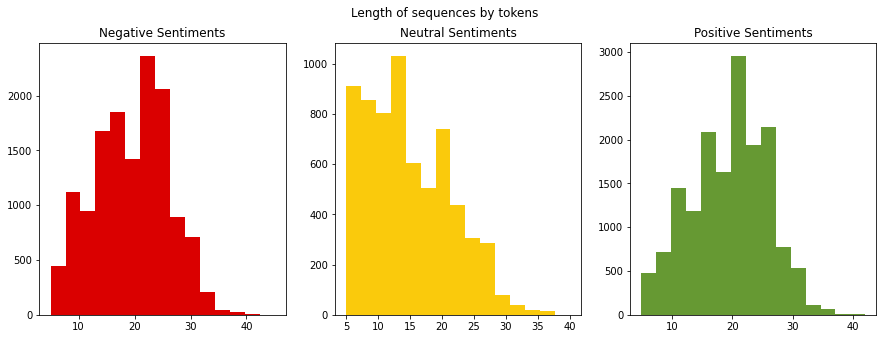

In [ ]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

tweet_len = train_df[train_df['Sentiment']==0]['word_length']
ax1.hist(tweet_len,color='#DA0000', bins=15)
ax1.set_title('Negative Sentiments')

tweet_len = train_df[train_df['Sentiment']==1]['word_length']
ax2.hist(tweet_len,color='#FACA0C', bins=15)
ax2.set_title('Neutral Sentiments')

tweet_len = train_df[train_df['Sentiment']==2]['word_length']
ax3.hist(tweet_len,color='#669933', bins=15)
ax3.set_title('Positive Sentiments')

fig.suptitle('Length of sequences by tokens')
plt.savefig('sequence_lengths.png')
plt.show()

In [ ]:
train_df['Sentiment'] = train_df['Sentiment'].map({0:'Negative', 1:'Neutral',2:'Positive'})
dev_df['Sentiment'] = dev_df['Sentiment'].map({0:'Negative', 1:'Neutral',2:'Positive'})

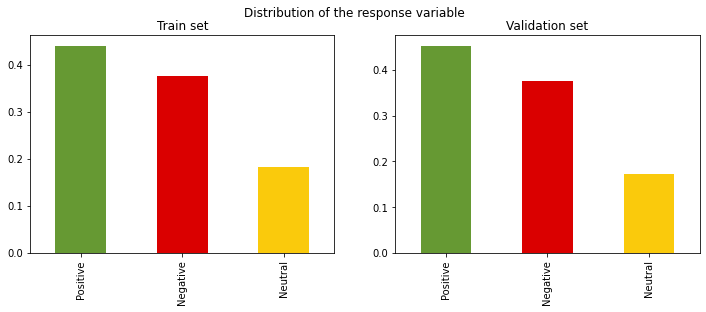

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
train_df.Sentiment.value_counts(normalize=True).plot(kind='bar', color=['#669933', '#DA0000', '#FACA0C'])
plt.title('Train set')

plt.subplot(1, 2, 2)
dev_df.Sentiment.value_counts(normalize=True).plot(kind='bar', color=['#669933', '#DA0000', '#FACA0C'])
plt.title('Validation set')

plt.suptitle('Distribution of the response variable')
plt.savefig('response_dist.png')
plt.show()

In [ ]:
train_df['Sentiment'] = train_df['Sentiment'].map({'Negative':0, 'Neutral':1, 'Positive':2})
dev_df['Sentiment'] = dev_df['Sentiment'].map({'Negative':0, 'Neutral':1, 'Positive':2})

In [ ]:
def build_vocab(sentences, verbose =  True):
    """
    Just to check the occurrences of words.
    Keys are the words, values are the occurrences.
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [ ]:
sentences = df["content_words"]
vocab = build_vocab(sentences)

  0%|          | 0/44955 [00:00<?, ?it/s]

In [ ]:
from collections import Counter
c = Counter(vocab)
most_commons = c.most_common(15)
most_commons.sort(key=lambda x: x[1])

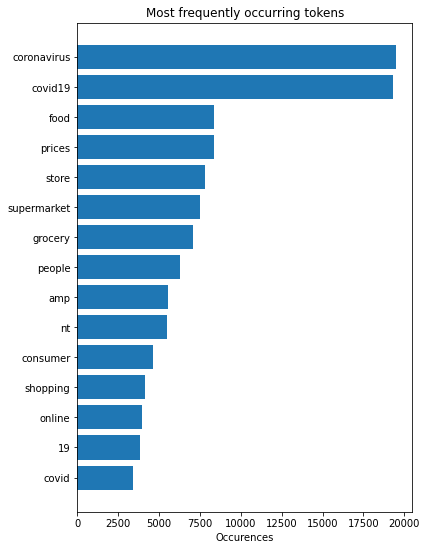

In [ ]:
plt.rcParams["figure.figsize"] = (6,9)
plt.barh(*zip(*most_commons))
plt.title('Most frequently occurring tokens')
plt.xlabel('Occurences')
plt.savefig('token_occurences.png')
plt.show()

## Padding

In [ ]:
maxlen = train_df.word_encoded.apply(len).max()
print(maxlen)

def pad_sequence(sequence):
    if len(sequence) > maxlen:
        return sequence[:maxlen]
    return sequence + [word_tokenizer.vocab['[PAD]'] for _ in range(maxlen-len(sequence))]

45


In [ ]:
train_df['padded'] = train_df.word_encoded.apply(pad_sequence)
dev_df['padded'] = dev_df.word_encoded.apply(pad_sequence)
test_df['padded'] = test_df.word_encoded.apply(pad_sequence)

train_df['padded'].apply(len).value_counts()

45    36476
Name: padded, dtype: int64

## Input and Output tensors

### Random Over Sampling

I ran some experiments with oversampled data, but I cannot obtain better results. (The final version of the notebook only contains the best obtained experiments.) Usually this ratio of the response variable cannot be considered unbalanced, nevertheless I have tried.

In [ ]:
# X_train = train_df.drop(['Sentiment'], axis=1)
# y_train = train_df['Sentiment']

In [ ]:
# from imblearn.over_sampling import RandomOverSampler

In [ ]:
# ros = RandomOverSampler(random_state=0)
# X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

### Extracting the tensors

In [ ]:
""""X_train = torch.from_numpy(np.array(list(X_train_res.padded))).to(device)
y_train = torch.LongTensor(y_train_res).to(device)
seqlen_train = torch.LongTensor(X_train_res.word_length.values)
print(f"X train size: {X_train.size()},\ny train size: {y_train.size()}\nseq_len train size: {seqlen_train.size()}\n")"""

X_train = torch.from_numpy(np.array(list(train_df.padded))).to(device)
y_train = torch.LongTensor(train_df.Sentiment.values).to(device)
seqlen_train = torch.LongTensor(train_df.word_length.values)
print(f"X train size: {X_train.size()},\ny train size: {y_train.size()}\nseq_len train size: {seqlen_train.size()}\n")

X_dev = torch.from_numpy(np.array(list(dev_df.padded))).to(device)
y_dev = torch.LongTensor(dev_df.Sentiment.values).to(device)
seqlen_dev = torch.LongTensor(dev_df.word_length.values)
print(f"X dev size: {X_dev.size()},\ny dev size: {y_dev.size()}\nseq_len dev size: {seqlen_dev.size()}\n")

X_test = torch.from_numpy(np.array(list(test_df.padded))).to(device)
y_test = torch.LongTensor(test_df.Sentiment.values).to(device)
seqlen_test = torch.LongTensor(test_df.word_length.values)
print(f"X test size: {X_test.size()},\ny test size: {y_test.size()}\nseq_len test size: {seqlen_test.size()}\n")

X train size: torch.Size([36476, 45]),
y train size: torch.Size([36476])
seq_len train size: torch.Size([36476])

X dev size: torch.Size([4053, 45]),
y dev size: torch.Size([4053])
seq_len dev size: torch.Size([4053])

X test size: torch.Size([3781, 45]),
y test size: torch.Size([3781])
seq_len test size: torch.Size([3781])



## Model

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.lstm = nn.LSTM(
            input_size=embedding_size,
            hidden_size=hidden_size,
            num_layers=1,
            bidirectional=True,
            batch_first=True,
            dropout = dropout
        )
        self.dense = nn.Linear(hidden_size * 2, output_size)
        self.dropout = nn.Dropout(dropout)
        
    # the input signature of forward changes
    def forward(self, sequences, sequence_lens):
        embedded = self.dropout(self.embedding(sequences))
        packed = nn.utils.rnn.pack_padded_sequence(
            embedded,
            sequence_lens.cpu().numpy(), # new: i use gpu so i have to implicitly put this to cpu as expected
            enforce_sorted=False,
            batch_first=True)
        packed_outputs, (h, c) = self.lstm(packed)
        # extract LSTM outputs (not used here)
        lstm_outputs, lens = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        
        h = self.dropout(torch.cat((h[0], h[1]), dim=-1))
        output = self.dense(h)
        return output

## Batch iterator

In [ ]:
class BatchedIterator:
    def __init__(self, *tensors, batch_size):
        # all tensors must have the same first dimension
        assert len(set(len(tensor) for tensor in tensors)) == 1
        self.tensors = tensors
        self.batch_size = batch_size
    
    def iterate_once(self):
        num_data = len(self.tensors[0])
        for start in range(0, num_data, self.batch_size):
            end = start + self.batch_size
            yield tuple(torch.tensor(tensor[start:end]).to(device) for tensor in self.tensors) # tensors on gpu
            
# sanity check            
print("Two tensors:")
for batch in BatchedIterator([1, 2, 3], [2, 1, 2], batch_size=2).iterate_once():
    print(batch)
    
print("\nOne tensor:")
for batch in BatchedIterator([2, 1, 2], batch_size=2).iterate_once():
    print(batch)

Two tensors:
(tensor([1, 2], device='cuda:0'), tensor([2, 1], device='cuda:0'))
(tensor([3], device='cuda:0'), tensor([2], device='cuda:0'))

One tensor:
(tensor([2, 1], device='cuda:0'),)
(tensor([2], device='cuda:0'),)


## Visualize model architecture

In [ ]:
input_size = len(word_tokenizer.vocab)
embedding_size = 80
hidden_size = 50
output_size = train_df.Sentiment.nunique()
dropout = 0.2

model = LSTMClassifier(input_size, embedding_size, hidden_size, output_size, dropout)
model = model.to(device)

In [ ]:
yhat = model(X_train, seqlen_train)

In [ ]:
make_dot(yhat, params=dict(list(model.named_parameters()))).render("lstm_torchviz", format="jpg")

'lstm_torchviz.jpg'

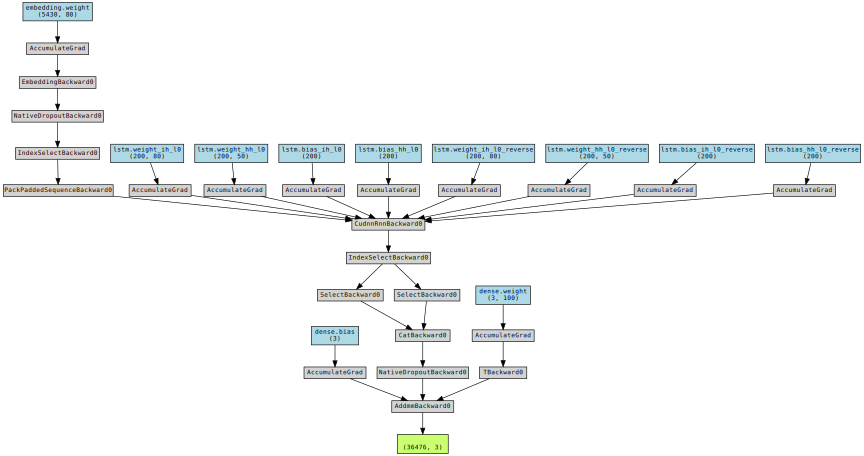

In [ ]:
make_dot(yhat, params=dict(list(model.named_parameters())))

## Training

In [ ]:
input_size = len(word_tokenizer.vocab)
embedding_size = 80
hidden_size = 50
output_size = train_df.Sentiment.nunique()
dropout = 0.2

model = LSTMClassifier(input_size, embedding_size, hidden_size, output_size, dropout)
model = model.to(device)

LEARNING_RATE = 0.0003
WEIGHT_DECAY = 0.0001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.05, patience=2, verbose = True)
# lmbda = lambda epoch: 0.9
# scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda, last_epoch=-1)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
num_epochs = 25
batch_size = 64

metrics = defaultdict(list)
train_iter = BatchedIterator(X_train, seqlen_train, y_train, batch_size=batch_size)

In [ ]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

In [ ]:
for epoch in range(num_epochs):
    model.train()
    # Training loop
    for X_batch, seqlen_batch, y_batch in train_iter.iterate_once():
        y_out = model(X_batch, seqlen_batch)
        loss = criterion(y_out, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        model.eval()  # or model.train(False)
        # Train and dev loss at the end of the epoch
        y_out = model(X_train, seqlen_train)
        train_loss = criterion(y_out, y_train).item()
        metrics['train_loss'].append(train_loss)
        labels = y_out.argmax(axis=1)
        train_bal_acc = balanced_accuracy_score(y_train.cpu().detach().numpy(), labels.cpu().detach().numpy())
        metrics['train_bal_acc'].append(train_bal_acc)

        y_out = model(X_dev, seqlen_dev)
        dev_loss = criterion(y_out, y_dev).item()
        metrics['dev_loss'].append(dev_loss)
        labels = y_out.argmax(axis=1)
        dev_bal_acc = balanced_accuracy_score(y_dev.cpu().detach().numpy(), labels.cpu().detach().numpy())
        metrics['dev_bal_acc'].append(dev_bal_acc)
    
    print(f"epoch={epoch} -- train loss={train_loss:.3f} - train acc={train_bal_acc:.1%} - dev loss={dev_loss:.3f} - dev acc={dev_bal_acc:.1%}")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


epoch=0 -- train loss=0.945 - train acc=45.6% - dev loss=0.942 - dev acc=45.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


epoch=1 -- train loss=0.856 - train acc=55.9% - dev loss=0.867 - dev acc=56.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


epoch=2 -- train loss=0.798 - train acc=60.3% - dev loss=0.817 - dev acc=59.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


epoch=3 -- train loss=0.746 - train acc=64.5% - dev loss=0.774 - dev acc=62.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


epoch=4 -- train loss=0.697 - train acc=67.6% - dev loss=0.733 - dev acc=65.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


epoch=5 -- train loss=0.649 - train acc=70.7% - dev loss=0.700 - dev acc=68.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


epoch=6 -- train loss=0.601 - train acc=74.4% - dev loss=0.661 - dev acc=70.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


epoch=7 -- train loss=0.563 - train acc=76.2% - dev loss=0.633 - dev acc=72.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


epoch=8 -- train loss=0.525 - train acc=79.0% - dev loss=0.607 - dev acc=74.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


epoch=9 -- train loss=0.495 - train acc=80.3% - dev loss=0.586 - dev acc=75.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


epoch=10 -- train loss=0.460 - train acc=82.6% - dev loss=0.559 - dev acc=77.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


epoch=11 -- train loss=0.438 - train acc=83.8% - dev loss=0.546 - dev acc=78.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


epoch=12 -- train loss=0.421 - train acc=84.7% - dev loss=0.536 - dev acc=79.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


epoch=13 -- train loss=0.400 - train acc=85.6% - dev loss=0.525 - dev acc=80.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


epoch=14 -- train loss=0.392 - train acc=86.1% - dev loss=0.526 - dev acc=80.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


epoch=15 -- train loss=0.374 - train acc=86.8% - dev loss=0.513 - dev acc=81.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


epoch=16 -- train loss=0.360 - train acc=87.2% - dev loss=0.505 - dev acc=81.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


epoch=17 -- train loss=0.350 - train acc=87.5% - dev loss=0.502 - dev acc=81.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


epoch=18 -- train loss=0.342 - train acc=88.0% - dev loss=0.503 - dev acc=82.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


epoch=19 -- train loss=0.330 - train acc=88.4% - dev loss=0.489 - dev acc=82.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


epoch=20 -- train loss=0.324 - train acc=88.5% - dev loss=0.487 - dev acc=82.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


epoch=21 -- train loss=0.318 - train acc=88.8% - dev loss=0.490 - dev acc=82.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


epoch=22 -- train loss=0.313 - train acc=89.1% - dev loss=0.492 - dev acc=82.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


epoch=23 -- train loss=0.308 - train acc=89.2% - dev loss=0.495 - dev acc=82.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


epoch=24 -- train loss=0.292 - train acc=89.6% - dev loss=0.485 - dev acc=82.8%


## Evaluation

### Learning curves

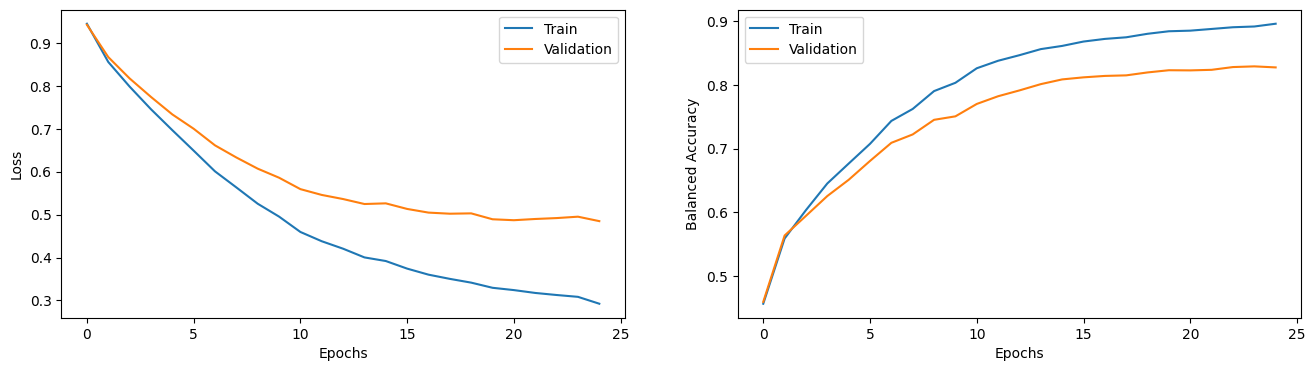

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)

fig, ax = plt.subplots(1, 2, figsize=(16, 4))

sns.lineplot(data=metrics['train_loss'], ax=ax[0], label='Train')
sns.lineplot(data=metrics['dev_loss'], ax=ax[0], label='Validation')

sns.lineplot(data=metrics['train_bal_acc'], ax=ax[1], label='Train')
sns.lineplot(data=metrics['dev_bal_acc'], ax=ax[1], label='Validation')

plt.setp(ax[0], xlabel='Epochs', ylabel='Loss')
plt.setp(ax[1], xlabel='Epochs', ylabel='Balanced Accuracy')
plt.savefig('no_pre-trained_loss_acc.png')
plt.show()

In [ ]:
pickle.dump(metrics, open(f'/content/drive/MyDrive/Deep Learning/Covid sentiment/metrics_no_pre_trained.pkl', 'wb'))

In [ ]:
metrics_no_pre_trained = pickle.load(open(f'/content/drive/MyDrive/Deep Learning/Covid sentiment/metrics_no_pre_trained.pkl', 'rb'))

### Classification reports

In [ ]:
def evaluation(y_pred, y_true):
    return ConfusionMatrixDisplay.from_predictions(y_pred=y_pred, y_true=y_true, cmap='Blues', display_labels=['Negative', 'Neutral', 'Positive']), print(classification_report(y_pred=y_pred, y_true=y_true))

#### Train

In [ ]:
with torch.no_grad():
    model.eval()
    y_out = model(X_train, seqlen_train)
    labels = y_out.argmax(axis=1)

              precision    recall  f1-score   support

           0       0.89      0.91      0.90     13755
           1       0.88      0.86      0.87      6602
           2       0.92      0.92      0.92     16119

    accuracy                           0.91     36476
   macro avg       0.90      0.90      0.90     36476
weighted avg       0.91      0.91      0.91     36476



(<sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x7f95807c1050>,
 None)

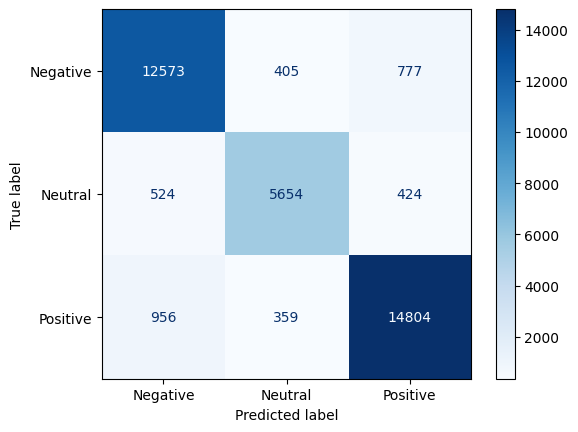

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)
evaluation(labels.cpu().detach().numpy(), y_train.cpu().detach().numpy())

In [ ]:
np.round(balanced_accuracy_score(y_train.cpu().detach().numpy(), labels.cpu().detach().numpy()), 3)

0.896

#### Validation

In [ ]:
with torch.no_grad():
    model.eval()
    y_out = model(X_dev, seqlen_dev)
    labels = y_out.argmax(axis=1)

              precision    recall  f1-score   support

           0       0.83      0.84      0.83      1528
           1       0.77      0.78      0.78       734
           2       0.87      0.86      0.87      1791

    accuracy                           0.84      4053
   macro avg       0.83      0.83      0.83      4053
weighted avg       0.84      0.84      0.84      4053



(<sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x7f957f4e2e90>,
 None)

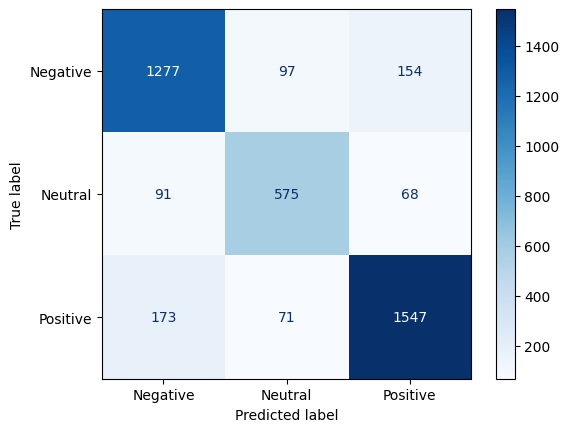

In [ ]:
evaluation(labels.cpu().detach().numpy(), y_dev.cpu().detach().numpy())

In [ ]:
np.round(balanced_accuracy_score(y_dev.cpu().detach().numpy(), labels.cpu().detach().numpy()), 3)

0.828

#### Test

In [ ]:
with torch.no_grad():
    model.eval()
    y_out = model(X_test, seqlen_test)
    labels = y_out.argmax(axis=1)

              precision    recall  f1-score   support

           0       0.81      0.82      0.81      1632
           1       0.74      0.75      0.74       605
           2       0.84      0.84      0.84      1544

    accuracy                           0.81      3781
   macro avg       0.80      0.80      0.80      3781
weighted avg       0.81      0.81      0.81      3781



(<sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x7f957f349f10>,
 None)

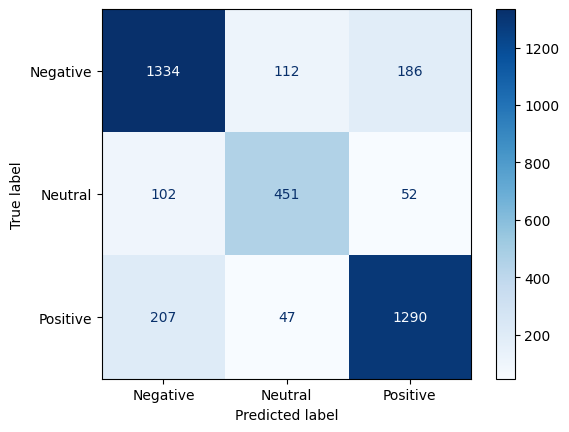

In [ ]:
evaluation(labels.cpu().detach().numpy(), y_test.cpu().detach().numpy())

In [ ]:
np.round(balanced_accuracy_score(y_test.cpu().detach().numpy(), labels.cpu().detach().numpy()), 3)

0.799

# With pre-trained embeddings

## Import

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Deep Learning/Covid sentiment/Corona_NLP_train.csv', encoding='ISO-8859-1')
test_df = pd.read_csv('/content/drive/MyDrive/Deep Learning/Covid sentiment/Corona_NLP_test.csv')

train_df = train_df[['OriginalTweet', 'Sentiment']]
test_df = test_df[['OriginalTweet', 'Sentiment']]

train_df['Sentiment'] = train_df['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})
test_df['Sentiment'] = test_df['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


## Data cleaning

In [ ]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [ ]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS

#Clean emojis from text
def strip_emoji(text):
    return re.sub(emoji.get_emoji_regexp(), r"", text) #remove emoji

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

def remove_url(text):
    return re.sub(r'http\S+', '', text)

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

In [ ]:
train_df['OriginalTweet'] = train_df['OriginalTweet'].apply(lambda x: strip_emoji(x))
test_df['OriginalTweet'] = test_df['OriginalTweet'].apply(lambda x: strip_emoji(x))

train_df['OriginalTweet'] = train_df['OriginalTweet'].apply(lambda x: strip_all_entities(x))
test_df['OriginalTweet'] = test_df['OriginalTweet'].apply(lambda x: strip_all_entities(x))

train_df['OriginalTweet'] = train_df['OriginalTweet'].apply(lambda x: clean_hashtags(x))
test_df['OriginalTweet'] = test_df['OriginalTweet'].apply(lambda x: clean_hashtags(x))

train_df['OriginalTweet'] = train_df['OriginalTweet'].apply(lambda x: filter_chars(x))
test_df['OriginalTweet'] = test_df['OriginalTweet'].apply(lambda x: filter_chars(x))

train_df['OriginalTweet'] = train_df['OriginalTweet'].apply(lambda x: remove_mult_spaces(x))
test_df['OriginalTweet'] = test_df['OriginalTweet'].apply(lambda x: remove_mult_spaces(x))

train_df['OriginalTweet'] = train_df['OriginalTweet'].apply(lambda x: remove_stopwords(x))
test_df['OriginalTweet'] = test_df['OriginalTweet'].apply(lambda x: remove_stopwords(x))

train_df['OriginalTweet'] = train_df['OriginalTweet'].apply(lambda x: remove_url(x))
test_df['OriginalTweet'] = test_df['OriginalTweet'].apply(lambda x: remove_url(x))

train_df['OriginalTweet'] = train_df['OriginalTweet'].apply(lambda x: denoise_text(x))
test_df['OriginalTweet'] = test_df['OriginalTweet'].apply(lambda x: denoise_text(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  """


Glove only has embedding for the word coronavirus, that is why I make the corrections below.

In [ ]:
train_df['OriginalTweet'] = train_df['OriginalTweet'].str.replace('covid19','coronavirus')
test_df['OriginalTweet'] = test_df['OriginalTweet'].str.replace('covid19','coronavirus')

train_df['OriginalTweet'] = train_df['OriginalTweet'].str.replace('covid 19','coronavirus')
test_df['OriginalTweet'] = test_df['OriginalTweet'].str.replace('covid 19','coronavirus')

train_df['OriginalTweet'] = train_df['OriginalTweet'].str.replace('covid','coronavirus')
test_df['OriginalTweet'] = test_df['OriginalTweet'].str.replace('covid','coronavirus')

## Vocabulary

In [ ]:
df = pd.concat([train_df, test_df], ignore_index=True)

In [ ]:
content_words=[]

for text in tqdm(df['OriginalTweet']):
    with nlp.disable_pipes("tagger","parser","ner"):
        doc = nlp(text)
        content_words.append([token.text.lower() for token in doc])

  0%|          | 0/44955 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [ ]:
df['content_words'] = content_words

In [ ]:
df['len'] = [len(content) for content in df['content_words']]

In [ ]:
class WordTokenizer(): # occurrences of the words in the corpus
    def __init__(self, tok_seqs, threshold=15): 
        tok_counts={} # keys: words, values: occurrences
        
        for tok_seq in tqdm(tok_seqs): # iterate over the list of words in each row in the df
            for tok in tok_seq:
                if not tok in tok_counts.keys():
                    tok_counts[tok]=1
                else:
                    tok_counts[tok]+=1
        
        self.vocab={'[PAD]':0,'[UNK]':1} # initialize vocab attribute with padding and unknown
        for tok, val in tok_counts.items(): # iterate over the values in the previously created dictionary (words:occurrences dict)
            if val>=threshold:
                self.vocab[tok]=len(self.vocab) # the keys are words that have at least 'threshold' occurrences and the values are integers (starting from 2) -> values are unique too
                
        print("The size of the dictionary:",len(self.vocab))
    def encode(self,seq):
        encoded=[]
        for tok in seq: # iterate over the list of words in each row in the df
            if tok in self.vocab.keys(): # if the word is in the previously created vocab (where the values are unique)
                encoded.append(self.vocab[tok]) # append the value (the integer encoding of the word)
            else:
                encoded.append(1) # if the word does not have at least 'threshold' occurrences then label those as unknown word (with value 1)
        return encoded

In [ ]:
word_tokenizer = WordTokenizer(df['content_words'])
df['word_encoded'] = [word_tokenizer.encode(seq) for seq in tqdm(df['content_words'])] # unqiue integer representation of each words which has at least 'threshold' occ or 1 if not
df['word_length'] = [len(seq) for seq in tqdm(df['content_words'])] # length of the encoded lists in each row of the df

  0%|          | 0/44955 [00:00<?, ?it/s]

The size of the dictionary: 5430


  0%|          | 0/44955 [00:00<?, ?it/s]

  0%|          | 0/44955 [00:00<?, ?it/s]

## Load pre-trained embeddings

### Glove 6B 50D 

In [ ]:
words = []
idx = 0
word2idx = {}
vectors = bcolz.carray(np.zeros(1), rootdir=f'/content/drive/MyDrive/Deep Learning/Covid sentiment/6B.50.dat', mode='w')

with open(f'/content/drive/MyDrive/Deep Learning/Covid sentiment/glove.6B.50d.txt', 'rb') as f:
    for l in f:
        line = l.decode().split()
        word = line[0]
        words.append(word)
        word2idx[word] = idx
        idx += 1
        vect = np.array(line[1:]).astype(np.float)
        vectors.append(vect)
    
vectors = bcolz.carray(vectors[1:].reshape((400001, 50)), rootdir=f'/content/drive/MyDrive/Deep Learning/Covid sentiment/6B.50.dat', mode='w')
vectors.flush()
pickle.dump(words, open(f'/content/drive/MyDrive/Deep Learning/Covid sentiment/6B.50_words.pkl', 'wb'))
pickle.dump(word2idx, open(f'/content/drive/MyDrive/Deep Learning/Covid sentiment/6B.50_idx.pkl', 'wb'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]


In [ ]:
vectors = bcolz.open(f'/content/drive/MyDrive/Deep Learning/Covid sentiment/6B.50.dat')[:]
words = pickle.load(open(f'/content/drive/MyDrive/Deep Learning/Covid sentiment/6B.50_words.pkl', 'rb'))
word2idx = pickle.load(open(f'/content/drive/MyDrive/Deep Learning/Covid sentiment/6B.50_idx.pkl', 'rb'))

glove = {w: vectors[word2idx[w]] for w in words}

In [ ]:
len(word_tokenizer.vocab)

5430

In [ ]:
len(glove)

400001

In [ ]:
matrix_len = len(word_tokenizer.vocab)
weights_matrix = np.zeros((matrix_len, 50))
words_found = 0

for i, word in enumerate(word_tokenizer.vocab):
    try: 
        weights_matrix[i] = glove[word]
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(50, ))

In [ ]:
words_found / len(word_tokenizer.vocab)

0.9488029465930018

#### Token occurrences

In [ ]:
def build_vocab(sentences, verbose =  True):
    """
    Just to check the occurrences of words.
    Keys are the words, values are the occurrences.
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [ ]:
sentences = df["content_words"]
vocab = build_vocab(sentences)

  0%|          | 0/44955 [00:00<?, ?it/s]

In [ ]:
from collections import Counter
c = Counter(vocab)
c.most_common(25)

[('coronavirus', 42224),
 ('food', 8380),
 ('prices', 8336),
 ('store', 7796),
 ('supermarket', 7510),
 ('grocery', 7051),
 ('people', 6262),
 ('amp', 5531),
 ('nt', 5450),
 ('consumer', 4646),
 ('shopping', 4123),
 ('online', 3928),
 ('pandemic', 3301),
 ('get', 3199),
 ('need', 3075),
 ('panic', 2944),
 ('us', 2868),
 ('stock', 2760),
 ('like', 2696),
 ('workers', 2658),
 ('go', 2515),
 ('time', 2498),
 ('home', 2461),
 ('sanitizer', 2436),
 ('demand', 2435)]

#### Visualize embeddings

In [ ]:
common_tokens = c.most_common(25)

common_embeddings = {}
for token_tuple in common_tokens:
    common_embeddings[token_tuple[0]] = glove[token_tuple[0]]

In [ ]:
embedding_df = pd.DataFrame.from_dict(common_embeddings, orient='index')

In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(embedding_df.values)

scaled_df = pd.DataFrame(scaled_features, index=embedding_df.index, columns=embedding_df.columns)

In [ ]:
X_corr=scaled_df.corr()

eigenvalues, eigenvectors=np.linalg.eig(X_corr)

args = (-eigenvalues).argsort()
values = eigenvectors[args]
vectors = eigenvectors[:, args]

new_vectors=vectors[:,:2]

#Projecting the embeddings onto new dimesions
new_coords = np.dot(scaled_features,new_vectors)

In [ ]:
occ_numbers = [np.sqrt(x[1]) for x in common_tokens]

In [ ]:
np.log(42224)

10.650744058743106

In [ ]:
np.sqrt(42224)

205.48479262466117

/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:153: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:828: ComplexWarning: Casting complex values to real discards the imaginary part
  x = float(self.convert_xunits(self._x))
/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:829: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(self._y))
/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:690: ComplexWarning: Casting complex values to real discards the imaginary part
  posx = float(textobj.convert_xunits(textobj._x))
/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:691: ComplexWarning: Casting complex values to real discards the imaginary part
  posy = float(textobj.convert_yunits(textobj._y))
/usr/local/lib/python3.7/dist-packages/adjustText/__init__.py:282: ComplexW

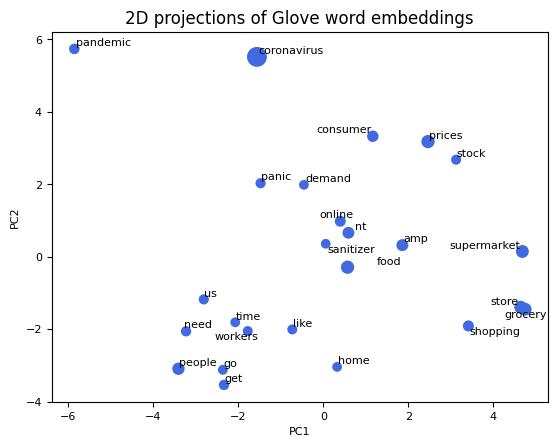

In [ ]:
def plot_embeddings(adjust=False, *args, **kwargs):
    plt.rcParams.update(plt.rcParamsDefault)
    #plt.figure(figsize=(16, 12))
    plt.scatter(new_coords[:,0], new_coords[:,1], s=occ_numbers, c='royalblue', edgecolors=(1,1,1,0))
    texts = []
    for x, y, s in zip(new_coords[:,0], new_coords[:,1], list(scaled_df.index)):
        texts.append(plt.text(x, y, s, size=8))
    if adjust:
        adjust_text(texts, precision=0.01, arrowprops=dict(arrowstyle="-", color='k', lw=0),
                                                save_steps=True, save_prefix='/content', **kwargs)
        plt.xlabel('PC1', fontsize=8)
        plt.ylabel('PC2', fontsize=8)
        plt.yticks(fontsize=8)
        plt.xticks(fontsize=8)
        plt.title('2D projections of Glove word embeddings')
        plt.savefig('embedding_viz_glove_2.png')
_ = plot_embeddings(adjust=True)

### Glove 6B 100D

In [ ]:
words = []
idx = 0
word2idx = {}
vectors = bcolz.carray(np.zeros(1), rootdir=f'/content/drive/MyDrive/Deep Learning/Covid sentiment/6B.100.dat', mode='w')

with open(f'/content/drive/MyDrive/Deep Learning/Covid sentiment/glove.6B.100d.txt', 'rb') as f:
    for l in f:
        line = l.decode().split()
        word = line[0]
        words.append(word)
        word2idx[word] = idx
        idx += 1
        vect = np.array(line[1:]).astype(np.float)
        vectors.append(vect)
    
vectors = bcolz.carray(vectors[1:].reshape((400001, 100)), rootdir=f'/content/drive/MyDrive/Deep Learning/Covid sentiment/6B.100.dat', mode='w')
vectors.flush()
pickle.dump(words, open(f'/content/drive/MyDrive/Deep Learning/Covid sentiment/6B.100_words.pkl', 'wb'))
pickle.dump(word2idx, open(f'/content/drive/MyDrive/Deep Learning/Covid sentiment/6B.100_idx.pkl', 'wb'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]


In [ ]:
vectors = bcolz.open(f'/content/drive/MyDrive/Deep Learning/Covid sentiment/6B.100.dat')[:]
words = pickle.load(open(f'/content/drive/MyDrive/Deep Learning/Covid sentiment/6B.100_words.pkl', 'rb'))
word2idx = pickle.load(open(f'/content/drive/MyDrive/Deep Learning/Covid sentiment/6B.100_idx.pkl', 'rb'))

glove = {w: vectors[word2idx[w]] for w in words}

In [ ]:
matrix_len = len(word_tokenizer.vocab)
weights_matrix = np.zeros((matrix_len, 100))
words_found = 0

for i, word in enumerate(word_tokenizer.vocab):
    try: 
        weights_matrix[i] = glove[word]
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(100, ))

In [ ]:
words_found / len(word_tokenizer.vocab)

0.9488029465930018

## Train-val-test split

In [ ]:
train_len = len(train_df)

train_df = df[:train_len]
test_df = df[train_len:]

train_df = train_df[train_df['len']>4]
test_df = test_df[test_df['len']>3]

train_df, dev_df = train_test_split(train_df, test_size=0.1)
# dev_df is the validation df 

In [ ]:
print(len(test_df)/len(train_df))
print(len(dev_df)/len(train_df))
print((len(test_df)+len(dev_df))/len(train_df))

0.10365535964022267
0.11111415800586832
0.21476951764609098


## Padding

In [ ]:
maxlen = train_df.word_encoded.apply(len).max()
print(maxlen)

def pad_sequence(sequence):
    if len(sequence) > maxlen:
        return sequence[:maxlen]
    return sequence + [word_tokenizer.vocab['[PAD]'] for _ in range(maxlen-len(sequence))]

44


In [ ]:
train_df['padded'] = train_df.word_encoded.apply(pad_sequence)
dev_df['padded'] = dev_df.word_encoded.apply(pad_sequence)

train_df['padded'].apply(len).value_counts()

44    36467
Name: padded, dtype: int64

In [ ]:
test_df['padded'] = test_df.word_encoded.apply(pad_sequence)

## Input and output tensors

In [ ]:
X_train = torch.from_numpy(np.array(list(train_df.padded))).to(device)
y_train = torch.LongTensor(train_df.Sentiment.values).to(device)
seqlen_train = torch.LongTensor(train_df.word_length.values)
print(f"X train size: {X_train.size()},\ny train size: {y_train.size()}\nseq_len train size: {seqlen_train.size()}\n")

X_dev = torch.from_numpy(np.array(list(dev_df.padded))).to(device)
y_dev = torch.LongTensor(dev_df.Sentiment.values).to(device)
seqlen_dev = torch.LongTensor(dev_df.word_length.values)
print(f"X dev size: {X_dev.size()},\ny dev size: {y_dev.size()}\nseq_len dev size: {seqlen_dev.size()}\n")

X_test = torch.from_numpy(np.array(list(test_df.padded))).to(device)
y_test = torch.LongTensor(test_df.Sentiment.values).to(device)
seqlen_test = torch.LongTensor(test_df.word_length.values)
print(f"X test size: {X_test.size()},\ny test size: {y_test.size()}\nseq_len test size: {seqlen_test.size()}\n")

X train size: torch.Size([36467, 44]),
y train size: torch.Size([36467])
seq_len train size: torch.Size([36467])

X dev size: torch.Size([4052, 44]),
y dev size: torch.Size([4052])
seq_len dev size: torch.Size([4052])

X test size: torch.Size([3780, 44]),
y test size: torch.Size([3780])
seq_len test size: torch.Size([3780])



## Model

In [ ]:
def create_emb_layer(weights_matrix, non_trainable=False):
    num_embeddings, embedding_dim = weights_matrix.size()
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim

In [ ]:
weights_matrix_torch = torch.FloatTensor(weights_matrix)

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, dropout, weights_matrix):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(weights_matrix, freeze=False)
        self.lstm = nn.LSTM(
            input_size=embedding_size,
            hidden_size=hidden_size,
            num_layers=1,
            bidirectional=True,
            batch_first=True,
            dropout = dropout
        )
        self.dense = nn.Linear(hidden_size * 2, output_size) # bidirectional lstm
        self.dropout = nn.Dropout(dropout)
        
    # forward pass
    def forward(self, sequences, sequence_lens):
        embedded = self.dropout(self.embedding(sequences))
        packed = nn.utils.rnn.pack_padded_sequence(
            embedded,
            sequence_lens.cpu().numpy(), # i use gpu for training, so i have to implicitly put this to cpu as expected
            enforce_sorted=False,
            batch_first=True)
        packed_outputs, (h, c) = self.lstm(packed)
        # extract LSTM outputs (not used here)
        lstm_outputs, lens = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        
        h = self.dropout(torch.cat((h[0], h[1]), dim=-1))
        output = self.dense(h)
        return output

## Batch iterator

In [ ]:
class BatchedIterator:
    def __init__(self, *tensors, batch_size):
        # all tensors must have the same first dimension
        assert len(set(len(tensor) for tensor in tensors)) == 1
        self.tensors = tensors
        self.batch_size = batch_size
    
    def iterate_once(self):
        num_data = len(self.tensors[0])
        for start in range(0, num_data, self.batch_size):
            end = start + self.batch_size
            yield tuple(torch.tensor(tensor[start:end]).to(device) for tensor in self.tensors)
            # put the obtained tensors to gpu
            
# sanity check:            
print("Two tensors:")
for batch in BatchedIterator([1, 2, 3], [2, 1, 2], batch_size=2).iterate_once():
    print(batch)
    
print("\nOne tensor:")
for batch in BatchedIterator([2, 1, 2], batch_size=2).iterate_once():
    print(batch)

Two tensors:
(tensor([1, 2], device='cuda:0'), tensor([2, 1], device='cuda:0'))
(tensor([3], device='cuda:0'), tensor([2], device='cuda:0'))

One tensor:
(tensor([2, 1], device='cuda:0'),)
(tensor([2], device='cuda:0'),)


## Training

In [ ]:
# hyperparams
input_size = weights_matrix_torch.size(0)
embedding_size = weights_matrix_torch.size(1)
hidden_size = 30
output_size = train_df.Sentiment.nunique()
dropout = 0.3

model = LSTMClassifier(input_size, embedding_size, hidden_size, output_size, dropout, weights_matrix_torch)
model = model.to(device)

LEARNING_RATE = 0.0003
WEIGHT_DECAY = 0.0002

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.05, patience=2, verbose = True)

# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
#lmbda = lambda epoch: 0.9
#scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda, last_epoch=-1)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
num_epochs = 13
batch_size = 64

metrics = defaultdict(list)
train_iter = BatchedIterator(X_train, seqlen_train, y_train, batch_size=batch_size)

In [ ]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

In [ ]:
for epoch in range(num_epochs):
    if epoch == 12:
        checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
        save_checkpoint(checkpoint)

    model.train()
    # Training loop
    for X_batch, seqlen_batch, y_batch in train_iter.iterate_once():
        y_out = model(X_batch, seqlen_batch)
        loss = criterion(y_out, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        model.eval()  # or model.train(False)
        # Train and dev loss at the end of the epoch
        y_out = model(X_train, seqlen_train)
        train_loss = criterion(y_out, y_train).item()
        metrics['train_loss'].append(train_loss)
        labels = y_out.argmax(axis=1)
        train_bal_acc = balanced_accuracy_score(y_train.cpu().detach().numpy(), labels.cpu().detach().numpy())
        metrics['train_bal_acc'].append(train_bal_acc)

        y_out = model(X_dev, seqlen_dev)
        dev_loss = criterion(y_out, y_dev).item()
        metrics['dev_loss'].append(dev_loss)
        labels = y_out.argmax(axis=1)
        dev_bal_acc = balanced_accuracy_score(y_dev.cpu().detach().numpy(), labels.cpu().detach().numpy())
        metrics['dev_bal_acc'].append(dev_bal_acc)

    print(f"epoch={epoch} -- train loss={train_loss:.3f} - train acc={train_bal_acc:.1%} - dev loss={dev_loss:.3f} - dev acc={dev_bal_acc:.1%}")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


epoch=0 -- train loss=0.871 - train acc=52.2% - dev loss=0.874 - dev acc=51.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


epoch=1 -- train loss=0.754 - train acc=63.0% - dev loss=0.775 - dev acc=61.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


epoch=2 -- train loss=0.675 - train acc=67.9% - dev loss=0.706 - dev acc=65.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


epoch=3 -- train loss=0.609 - train acc=72.5% - dev loss=0.654 - dev acc=69.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


epoch=4 -- train loss=0.556 - train acc=76.1% - dev loss=0.611 - dev acc=72.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


epoch=5 -- train loss=0.513 - train acc=79.3% - dev loss=0.579 - dev acc=75.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


epoch=6 -- train loss=0.479 - train acc=81.8% - dev loss=0.552 - dev acc=77.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


epoch=7 -- train loss=0.450 - train acc=83.6% - dev loss=0.531 - dev acc=78.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


epoch=8 -- train loss=0.427 - train acc=84.8% - dev loss=0.511 - dev acc=80.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


epoch=9 -- train loss=0.410 - train acc=85.6% - dev loss=0.500 - dev acc=81.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


epoch=10 -- train loss=0.393 - train acc=86.3% - dev loss=0.489 - dev acc=81.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


epoch=11 -- train loss=0.384 - train acc=86.7% - dev loss=0.485 - dev acc=82.4%
=> Saving checkpoint


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


epoch=12 -- train loss=0.374 - train acc=87.2% - dev loss=0.481 - dev acc=82.6%


## Evaluation

### Learning curves

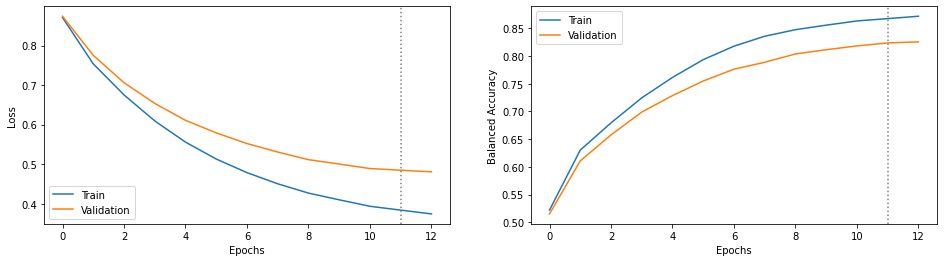

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

sns.lineplot(data=metrics['train_loss'], ax=ax[0], label='Train')
sns.lineplot(data=metrics['dev_loss'], ax=ax[0], label='Validation')

sns.lineplot(data=metrics['train_bal_acc'], ax=ax[1], label='Train')
sns.lineplot(data=metrics['dev_bal_acc'], ax=ax[1], label='Validation')

for axes in ax:
    axes.axvline(x=11, color='grey', linestyle=':')

plt.setp(ax[0], xlabel='Epochs', ylabel='Loss')
plt.setp(ax[1], xlabel='Epochs', ylabel='Balanced Accuracy')
plt.show()

### Classification reports

In [ ]:
def evaluation(y_pred, y_true):
    return ConfusionMatrixDisplay.from_predictions(y_pred=y_pred, y_true=y_true, cmap='Blues', display_labels=['Negative', 'Neutral', 'Positive']), print(classification_report(y_pred=y_pred, y_true=y_true))

#### Train

In [ ]:
load_checkpoint(torch.load('/content/my_checkpoint.pth.tar'))

=> Loading checkpoint


In [ ]:
with torch.no_grad():
    model.eval()
    y_out = model(X_train, seqlen_train)
    labels = y_out.argmax(axis=1)

              precision    recall  f1-score   support

           0       0.87      0.88      0.87     13766
           1       0.81      0.84      0.83      6629
           2       0.91      0.88      0.90     16072

    accuracy                           0.87     36467
   macro avg       0.86      0.87      0.86     36467
weighted avg       0.87      0.87      0.87     36467



(<sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x7fa9240eaad0>,
 None)

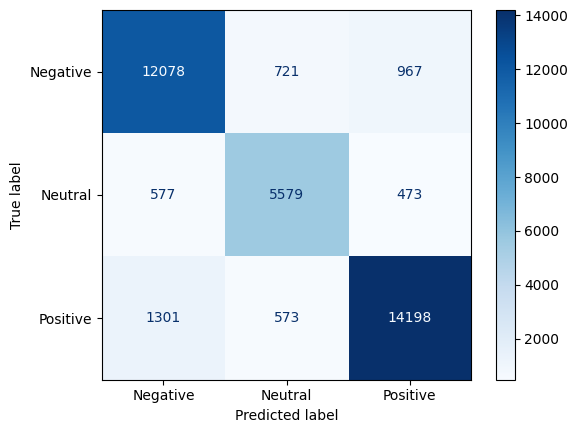

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)
evaluation(labels.cpu().detach().numpy(), y_train.cpu().detach().numpy())

In [ ]:
np.round(balanced_accuracy_score(y_train.cpu().detach().numpy(), labels.cpu().detach().numpy()), 3)

0.883

#### Validation

In [ ]:
with torch.no_grad():
    model.eval()
    y_out = model(X_dev, seqlen_dev)
    labels = y_out.argmax(axis=1)

              precision    recall  f1-score   support

           0       0.86      0.83      0.84      1559
           1       0.77      0.77      0.77       735
           2       0.86      0.89      0.87      1758

    accuracy                           0.84      4052
   macro avg       0.83      0.83      0.83      4052
weighted avg       0.84      0.84      0.84      4052



(<sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x7f6b8146b510>,
 None)

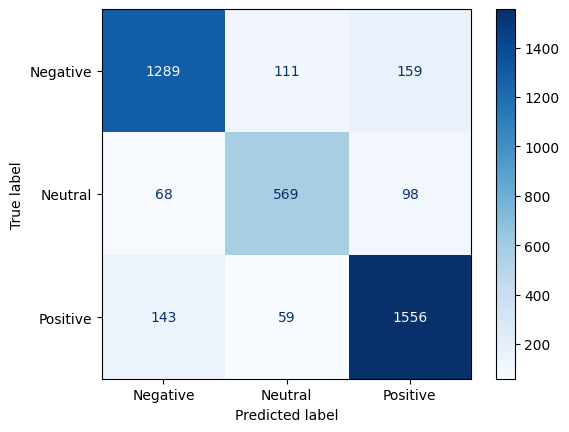

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)
evaluation(labels.cpu().detach().numpy(), y_dev.cpu().detach().numpy())

In [ ]:
np.round(balanced_accuracy_score(y_dev.cpu().detach().numpy(), labels.cpu().detach().numpy()), 3)

0.829

#### Test

In [ ]:
with torch.no_grad():
    model.eval()
    y_out = model(X_test, seqlen_test)
    labels = y_out.argmax(axis=1)

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1632
           1       0.70      0.75      0.73       604
           2       0.85      0.83      0.84      1544

    accuracy                           0.81      3780
   macro avg       0.79      0.80      0.79      3780
weighted avg       0.81      0.81      0.81      3780



(<sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x7fa92408dfd0>,
 None)

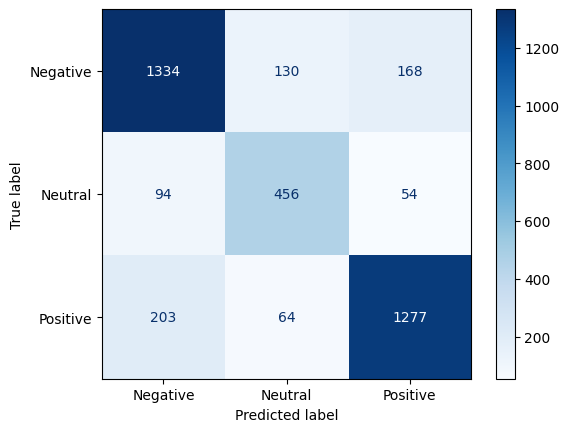

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)
evaluation(labels.cpu().detach().numpy(), y_test.cpu().detach().numpy())

In [ ]:
np.round(balanced_accuracy_score(y_test.cpu().detach().numpy(), labels.cpu().detach().numpy()), 3)

0.809